# Alternative cleavage site usage between PABPN1 mutants

In [1]:
###Load Packages

#Functions for polyA specific analysis (must be in same path)
from polyA_utils import *

#Packages for general column manipulation and statistics
import numpy as np
import pandas as pd
import csv
from tqdm import tqdm
from scipy import stats
import scipy.stats as sci
import pysam
from scipy.signal import find_peaks
import gffutils

#Packages for plotting
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("white")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Alternative cleavage site usage analyses for short read data were perfored using QAPA. Load in results dataframes for visualization. Compare 4SA vs 4SD (4SD set to reference condition)

In [2]:
#Set datapath for DESeq2 analyses
path = "/path/to/data"

In [6]:
figpath = "./"

In [3]:
#Define a function to calculate differences in PAS usage between conditions
def APA_differences(df, condition1, condition2):
    test_stat_list = []
    df_2 = pd.DataFrame(df)
    c1_df = df_2.filter(regex="PAU").filter(regex=condition1)
    c2_df = df_2.filter(regex="PAU").filter(regex=condition2)
    for idx, i in c1_df.iterrows():
        c1_values = i.values.tolist()
        c2_values = c2_df.iloc[idx].values.tolist()
        test_stat = stats.ttest_ind(c1_values, c2_values).pvalue
        test_stat_list.append(test_stat)
    df_2[condition1 + "_PAU_mean"] = df_2.filter(regex="PAU").filter(regex=condition1).mean(axis=1)
    df_2[condition2 + "_PAU_mean"] = df_2.filter(regex="PAU").filter(regex=condition2).mean(axis=1)
    df_2["log2FC"] = np.log2(df_2[condition2 + "_PAU_mean"]/df_2[condition1 + "_PAU_mean"])
    df_2["pvalue"] = test_stat_list
    df_2 = df_2.dropna()
    df_2["FDR"] = stats.false_discovery_control(list(df_2["pvalue"]))
    return(df_2)

In [4]:
#load in results DF and run the function to calculate differences in APA
data_df = pd.read_csv(path + "pau_results.txt", sep = "\t")
df_results = APA_differences(data_df, "h117", "h115")

/Users/jacksongordon/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/jacksongordon/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


Try to draw a line between points of the same transcript. Connect the dots between proximal and distal PAS usage

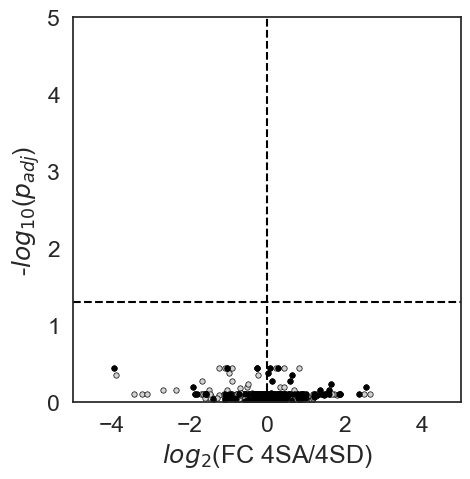

In [13]:
#Volcano plot to look at APA usage. More proximal or distal usage? 
f, ax = plt.subplots(1,1, figsize = (5,5))

sns.scatterplot(data = df_results, x = "log2FC", y = -np.log10(df_results["FDR"]), s = 15, alpha = 1, color = "lightgrey", edgecolor = "black", linewidth = 0.5)
sns.scatterplot(data = df_results.loc[df_results.APA_ID.str.contains("P")], x = "log2FC", y = -np.log10(df_results.loc[df_results.APA_ID.str.contains("P")]["FDR"]), color = "black", edgecolor = "black", linewidth = 0.5, s = 15)

# for i in np.unique(list(df_results.Gene_Name)):
#     sns.lineplot(data = df_results.loc[df_results.Gene_Name == i], x = "log2FC", y = -np.log10(df_results.loc[df_results.Gene_Name == i]["FDR"]), color = "black", linewidth = 1, alpha = 0.5)

ax.axhline(-np.log10(0.05), color = "black", linestyle = "--")
ax.axvline(0, color = "black", linestyle = "--")
ax.set_xlim(-5, 5)
ax.set_ylim(0,5)
ax.set_xlabel("$log_{2}$(FC 4SA/4SD)")
ax.set_ylabel("-$log_{10}$($p_{adj}$)")

plt.savefig(figpath + 'APA_4SAv4SD.png', dpi=300, bbox_inches="tight")


Same analysis with the long read data:

Compare EV to WT. Does overexpression of PABPN1 show reverse of KD in Cell paper?

In [348]:
#load in results DF and run the function to calculate differences in APA
data_df = pd.read_csv(path + "pau_results.txt", sep = "\t")
df_results_2 = APA_differences(data_df, "h112", "h113")

/Users/jacksongordon/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/jacksongordon/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [355]:
df_results_2.head()

,APA_ID,Transcript,Gene,Gene_Name,Chr,LastExon.Start,LastExon.End,Strand,UTR3.Start,UTR3.End,...,h115_R2_utr_quant.TPM,h115_R3_utr_quant.TPM,h117_R1_utr_quant.TPM,h117_R2_utr_quant.TPM,h117_R3_utr_quant.TPM,h112_PAU_mean,h113_PAU_mean,log2FC,pvalue,FDR
0,ENSG00000010017_1_D,ENST00000011619,ENSG00000010017,RANBP9,chr6,13621730,13622492,-,13621730,13622361,...,1214.025417,1996.105864,1685.322082,1307.987601,1692.356698,94.946000,81.201667,-0.225598,0.294318,0.642154
1,ENSG00000010017_2_D,ENST00000011619,ENSG00000010017,RANBP9,chr6,13621849,13622492,-,13621849,13622361,...,303.605232,0.000000,0.000000,0.000000,0.000000,5.054000,18.798333,1.895107,0.294318,0.642154
4,ENSG00000017797_2_D,ENST00000019317,ENSG00000017797,RALBP1,chr18,9535670,9537606,+,9535937,9537606,...,493.523541,687.991704,716.909135,579.217308,668.873560,87.415667,91.762667,0.070015,0.320025,0.642154
5,ENSG00000017797_3_D,ENST00000019317,ENSG00000017797,RALBP1,chr18,9535670,9538112,+,9535937,9538112,...,59.931201,101.869231,47.355661,37.616515,68.811540,12.584333,8.237333,-0.611380,0.320025,0.642154
6,ENSG00000031823_1_P,ENST00000034275,ENSG00000031823,RANBP3,chr19,5917326,5917653,-,5917326,5917609,...,0.000000,0.000000,176.659381,0.000000,0.000000,14.384333,23.529333,0.709962,0.596805,0.810442
